# Diorama TFA inversion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

from fatiando import utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.vis import mpl, myv
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
from matplotlib.mlab import normpdf

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


### Auxiliary functions

In [2]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing Diorama TFA data

In [3]:
grid_125 = np.loadtxt('anomalia-125m-cortada.txt')

In [4]:
yp = grid_125[:,0]
xp = grid_125[:,1]
zp = np.zeros(xp.size) - 100.
dobs = grid_125[:,2]

/home/leonardo/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


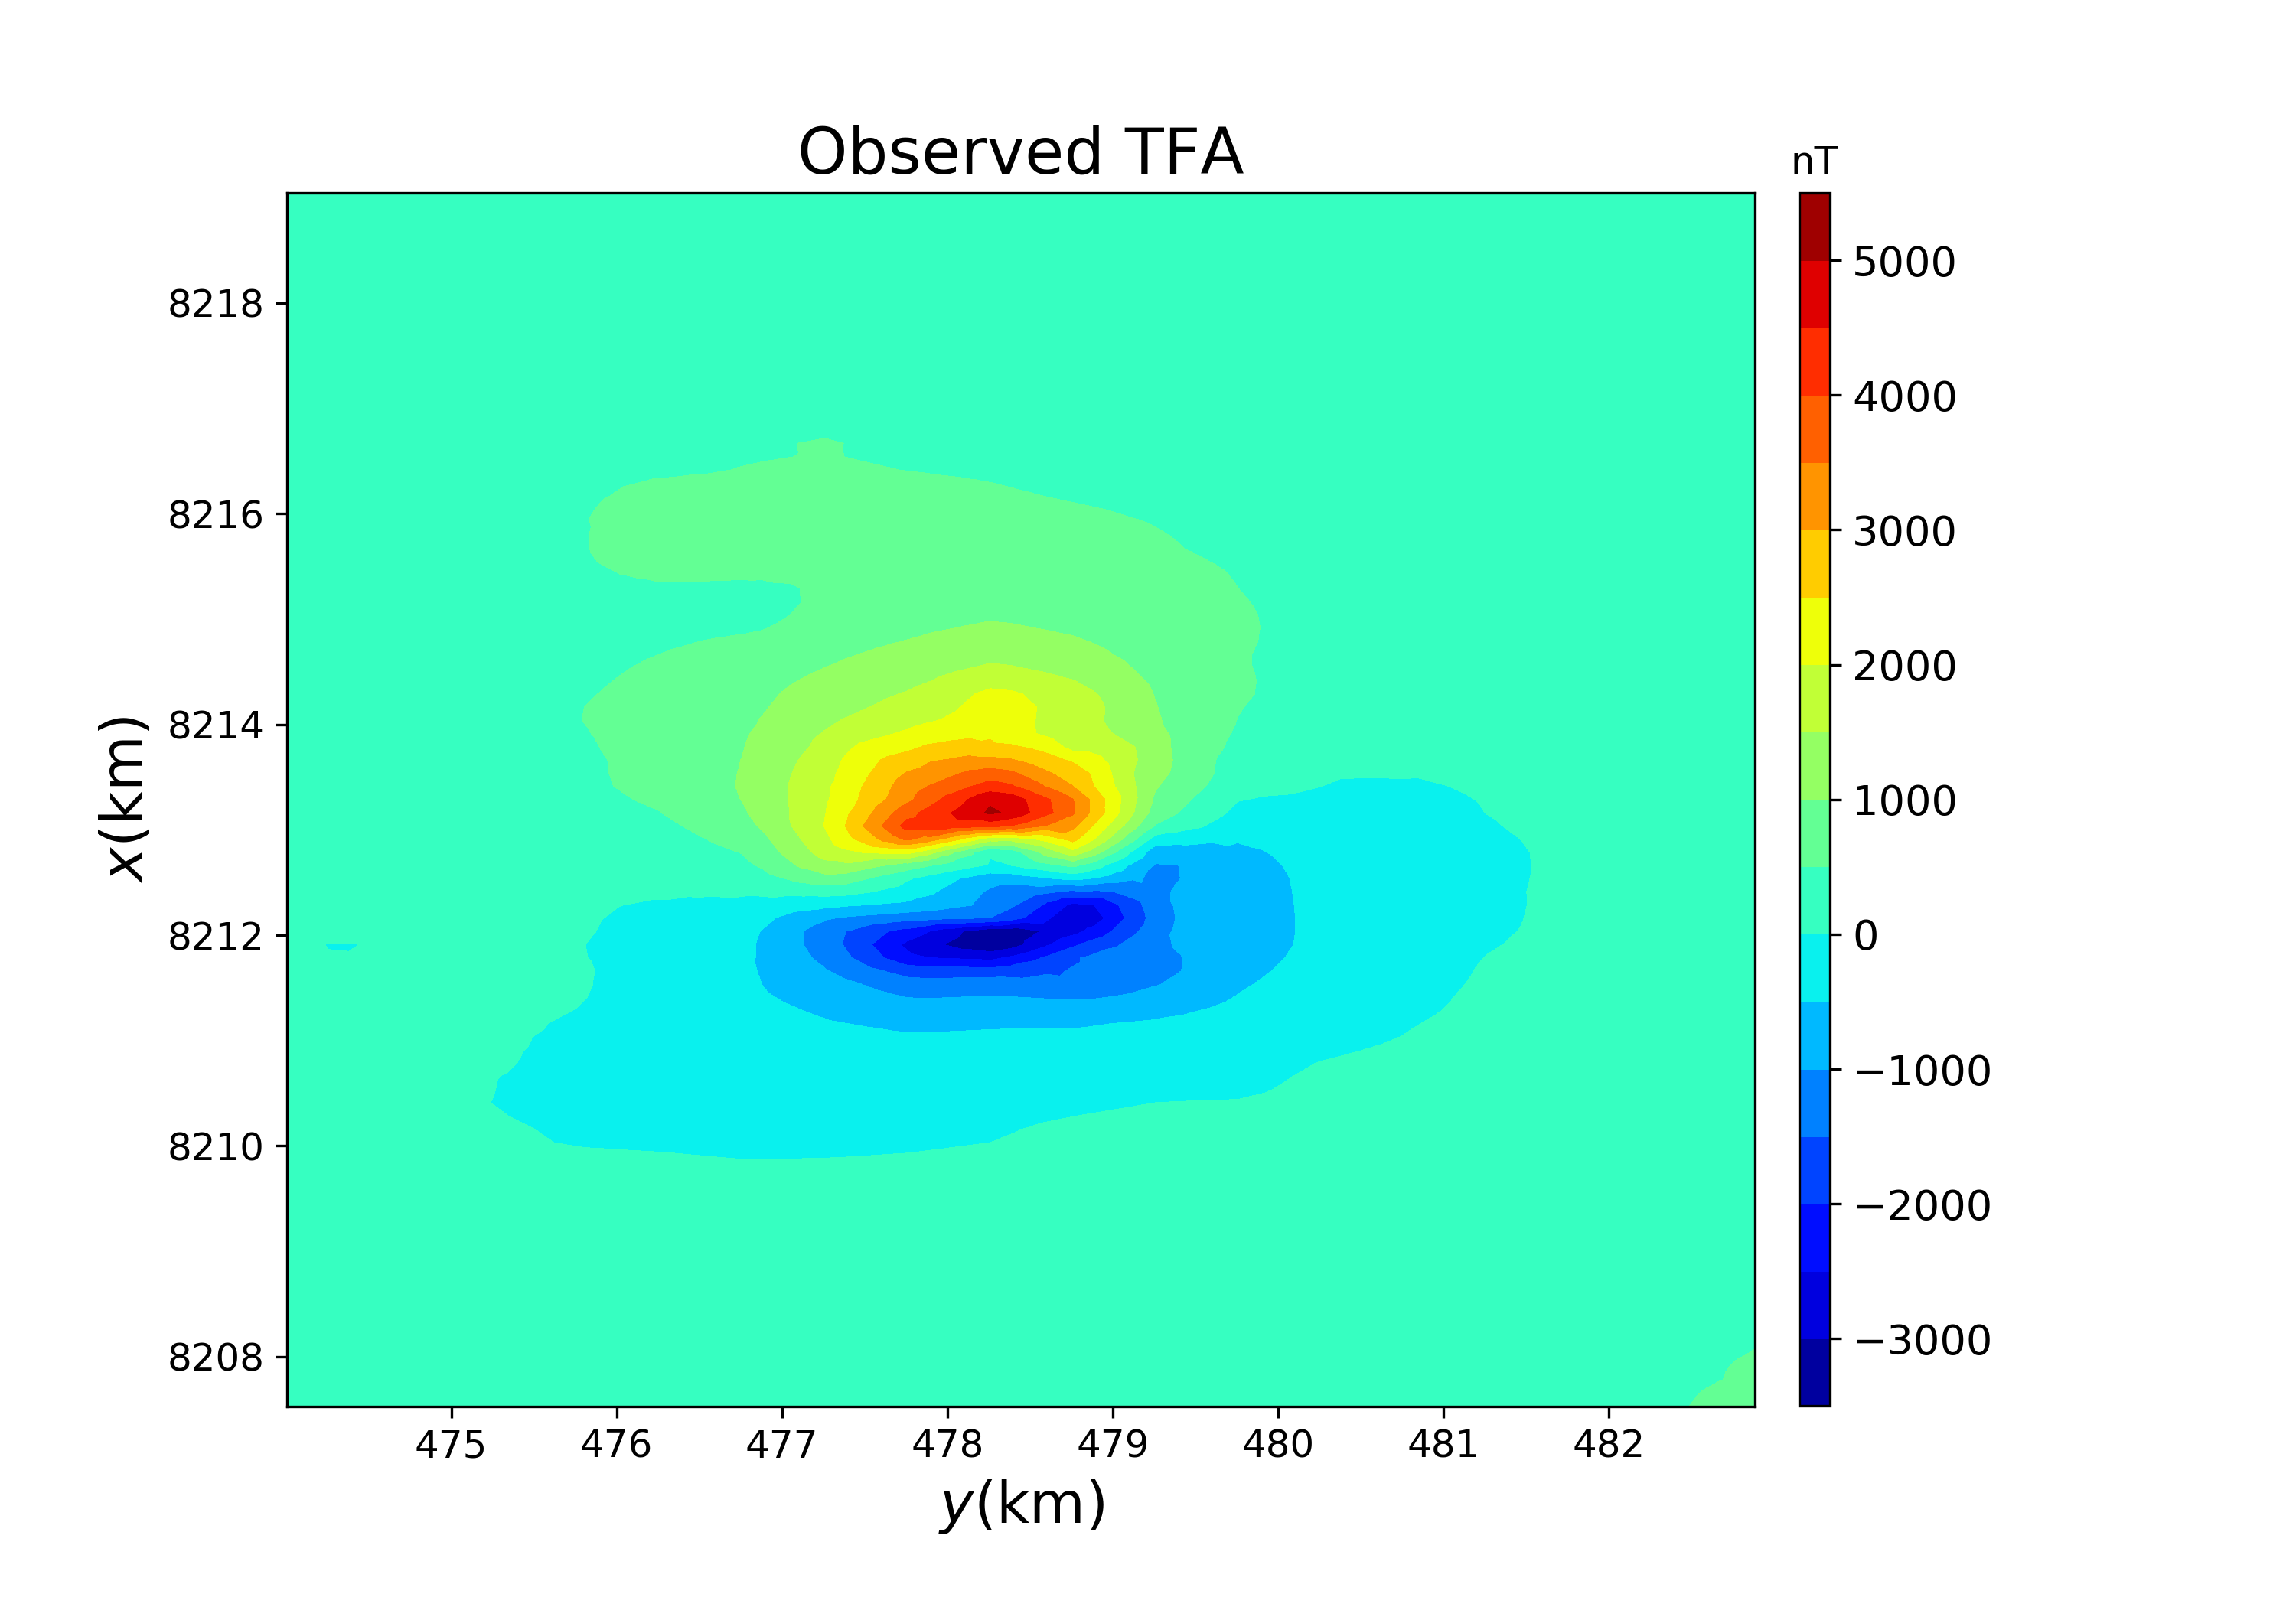

In [5]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1, norm=mpl.colors)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig('grid125.png', dpi=300)
#plt.show()
img(filename='grid125.png', width=1000, height=1200)

### Parameters for inversion

In [9]:
M = 20 # number of vertices per prism
L = 6 # number of prisms
P = L*(M+2) + 1 # number of parameters

# limits for parameters in meters
rmin = 10.
rmax = 4000.
x0min = 8211000.
x0max = 8214000.
y0min = 477000.
y0max = 479000.
dzmin = 10.
dzmax = 150.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

itmax = 50
itmax_marq = 15
epsilon = 1.0e-5     # stop criterion

deltax = 0.01*np.max(x0max)
deltay = 0.01*np.max(y0max)
deltar = 0.01*np.max(rmax)# increment of derivatives
deltaz = 0.01*np.max(dzmax)
m_out = np.zeros(M + 2)  # outcropping body parameters
#m_out = kimberlite_model['param_vec'][:M+2]

inc = -19.5
dec = -18.5

incs = -71.41751
decs = -23.39541
z0 = 200.
dz = 100.
props = {'magnetization': utils.ang2vec(
        25., incs, decs)}
N = xp.size

rin = np.zeros(M) + 1500.
m0 = np.hstack((rin, np.array([8212500., 478200.])))
m0 = np.resize(m0, P - 1) # inicial parameters vector
m0 = np.hstack((m0, dz))
model0 = mfun.param2polyprism(m0, M, L, z0, props) # list of classes of prisms
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec) # predict data

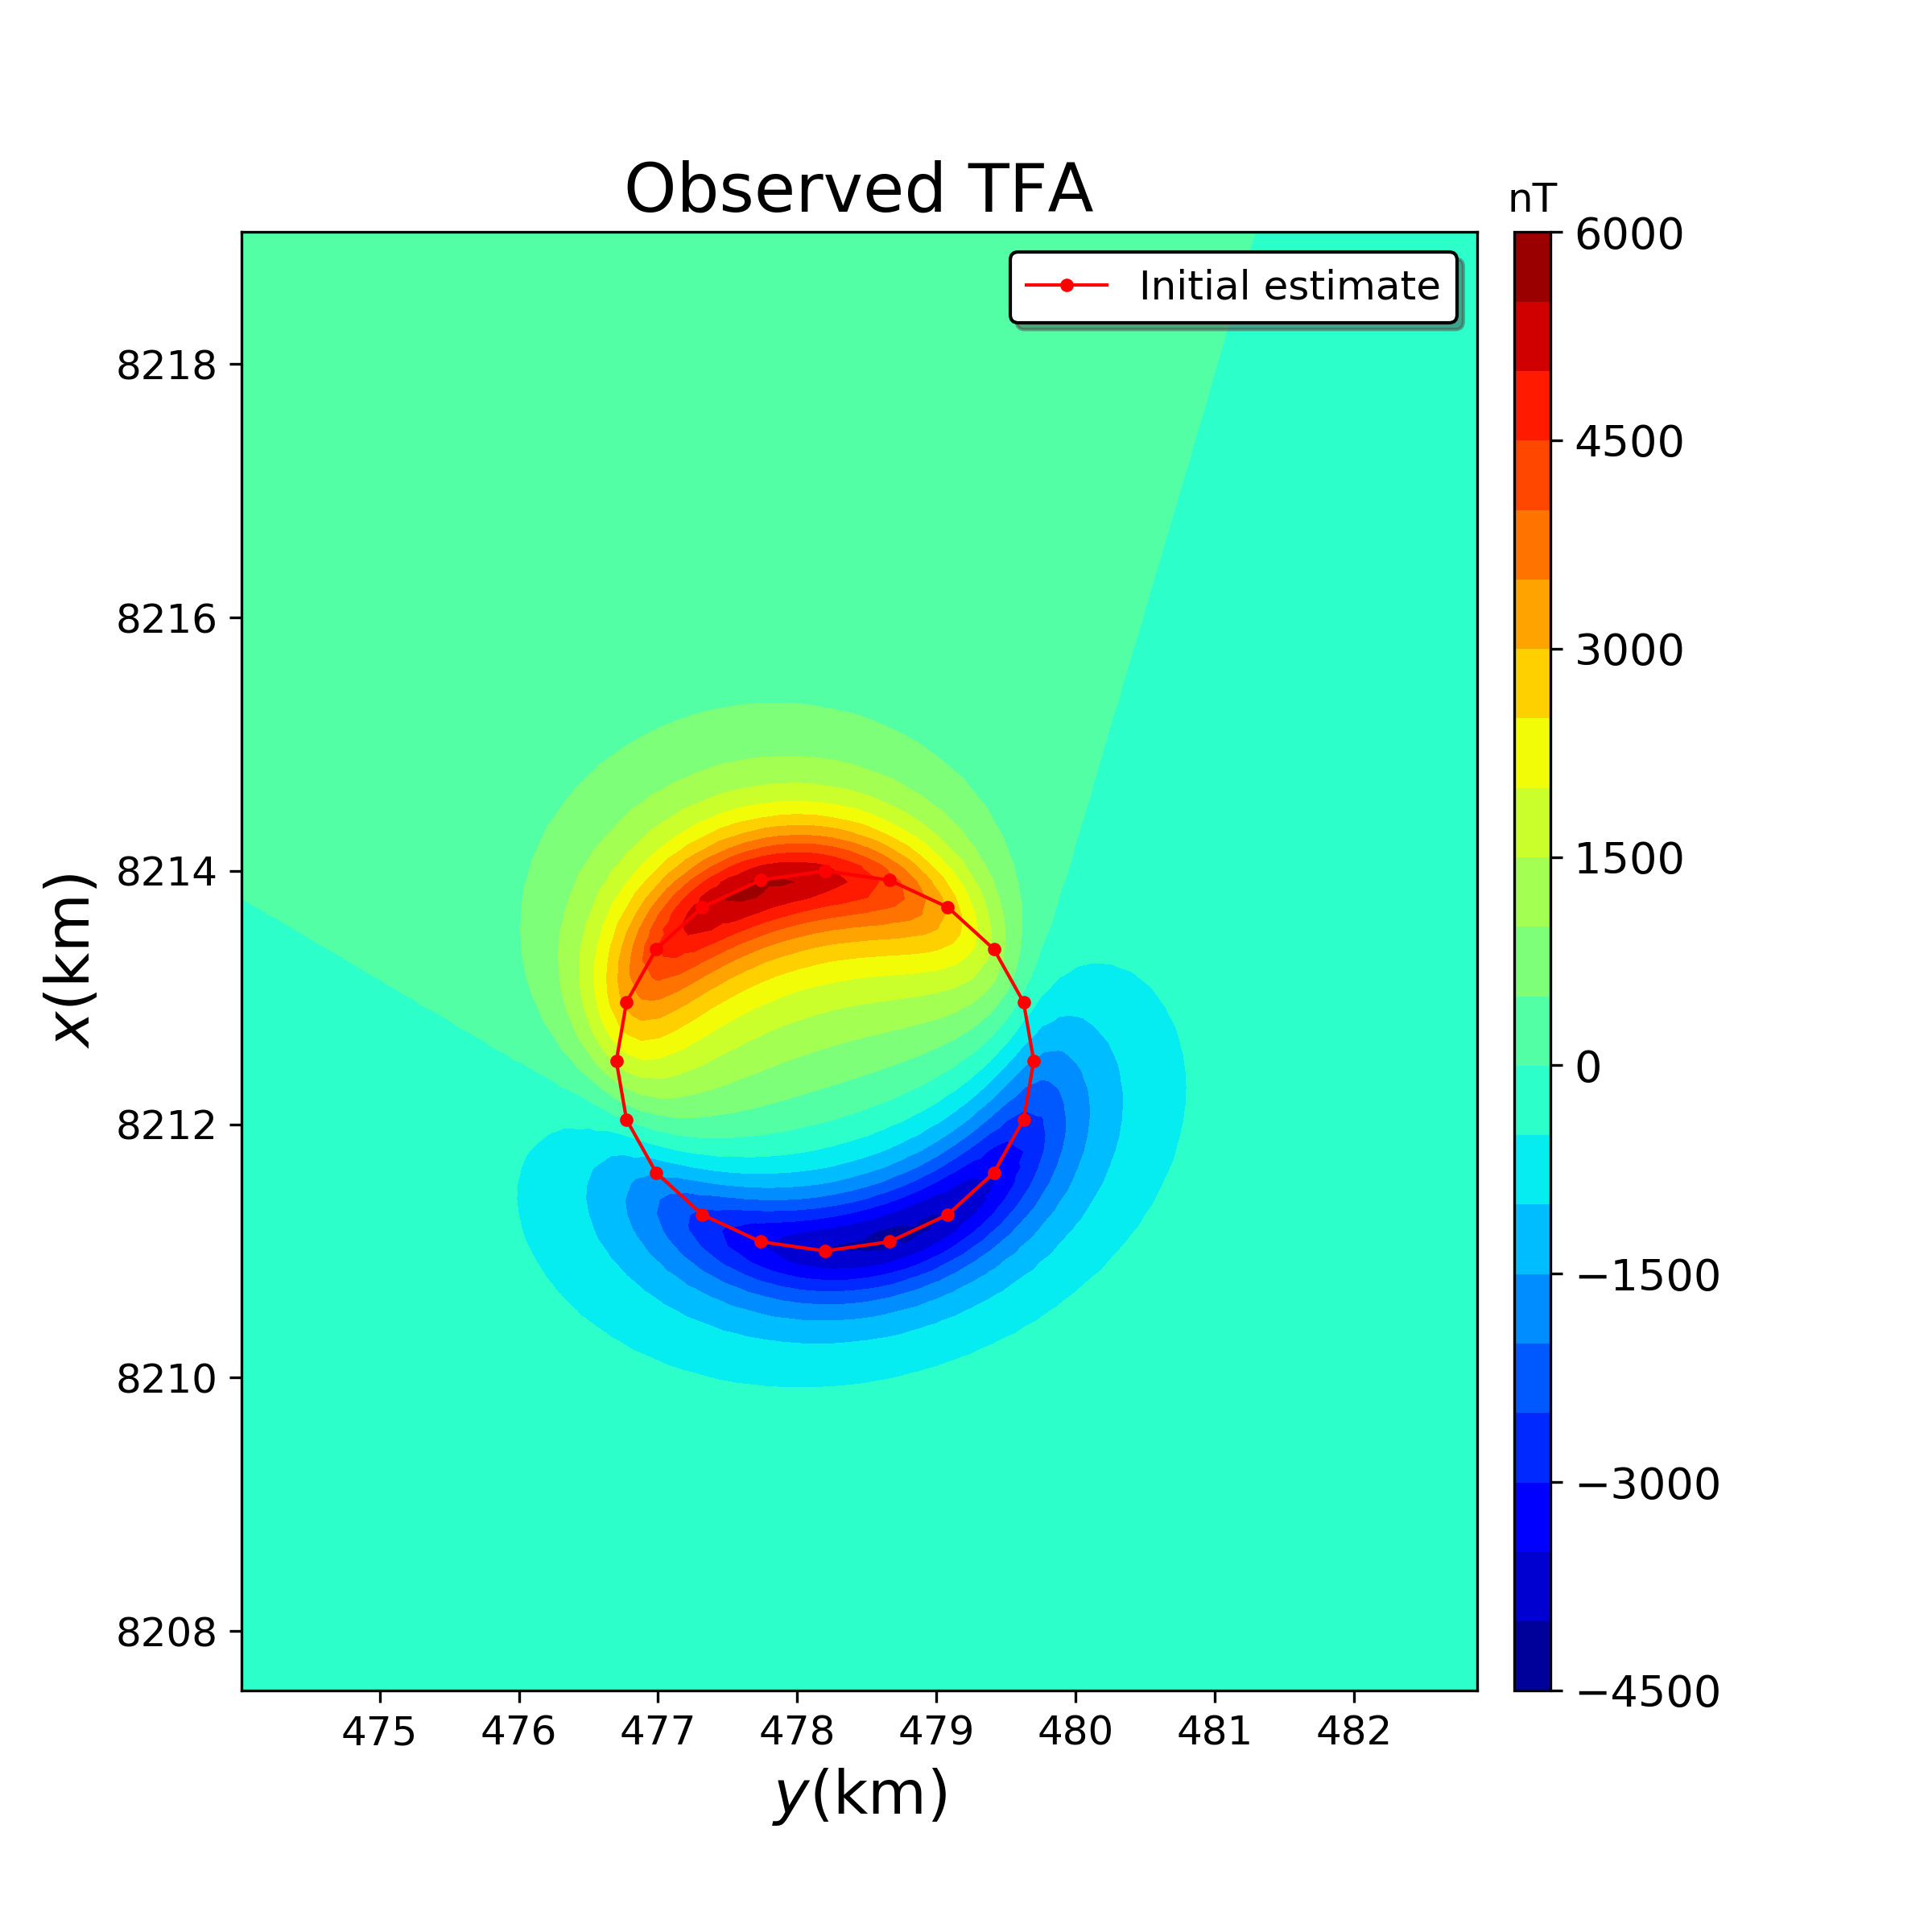

In [10]:
plt.figure(figsize=(8,8))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, d0, 20, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(kimberlite_model['prisms'][0], '.-k', xy2ne=True)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#source.set_label('Outcropping polygon')
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig('diorama_tfa_pred_data_true_inital.png', dpi=300)
#plt.show()

img(filename='diorama_tfa_pred_data_true_inital.png', width=800, height=800)

### Observed TFA with initial estimate

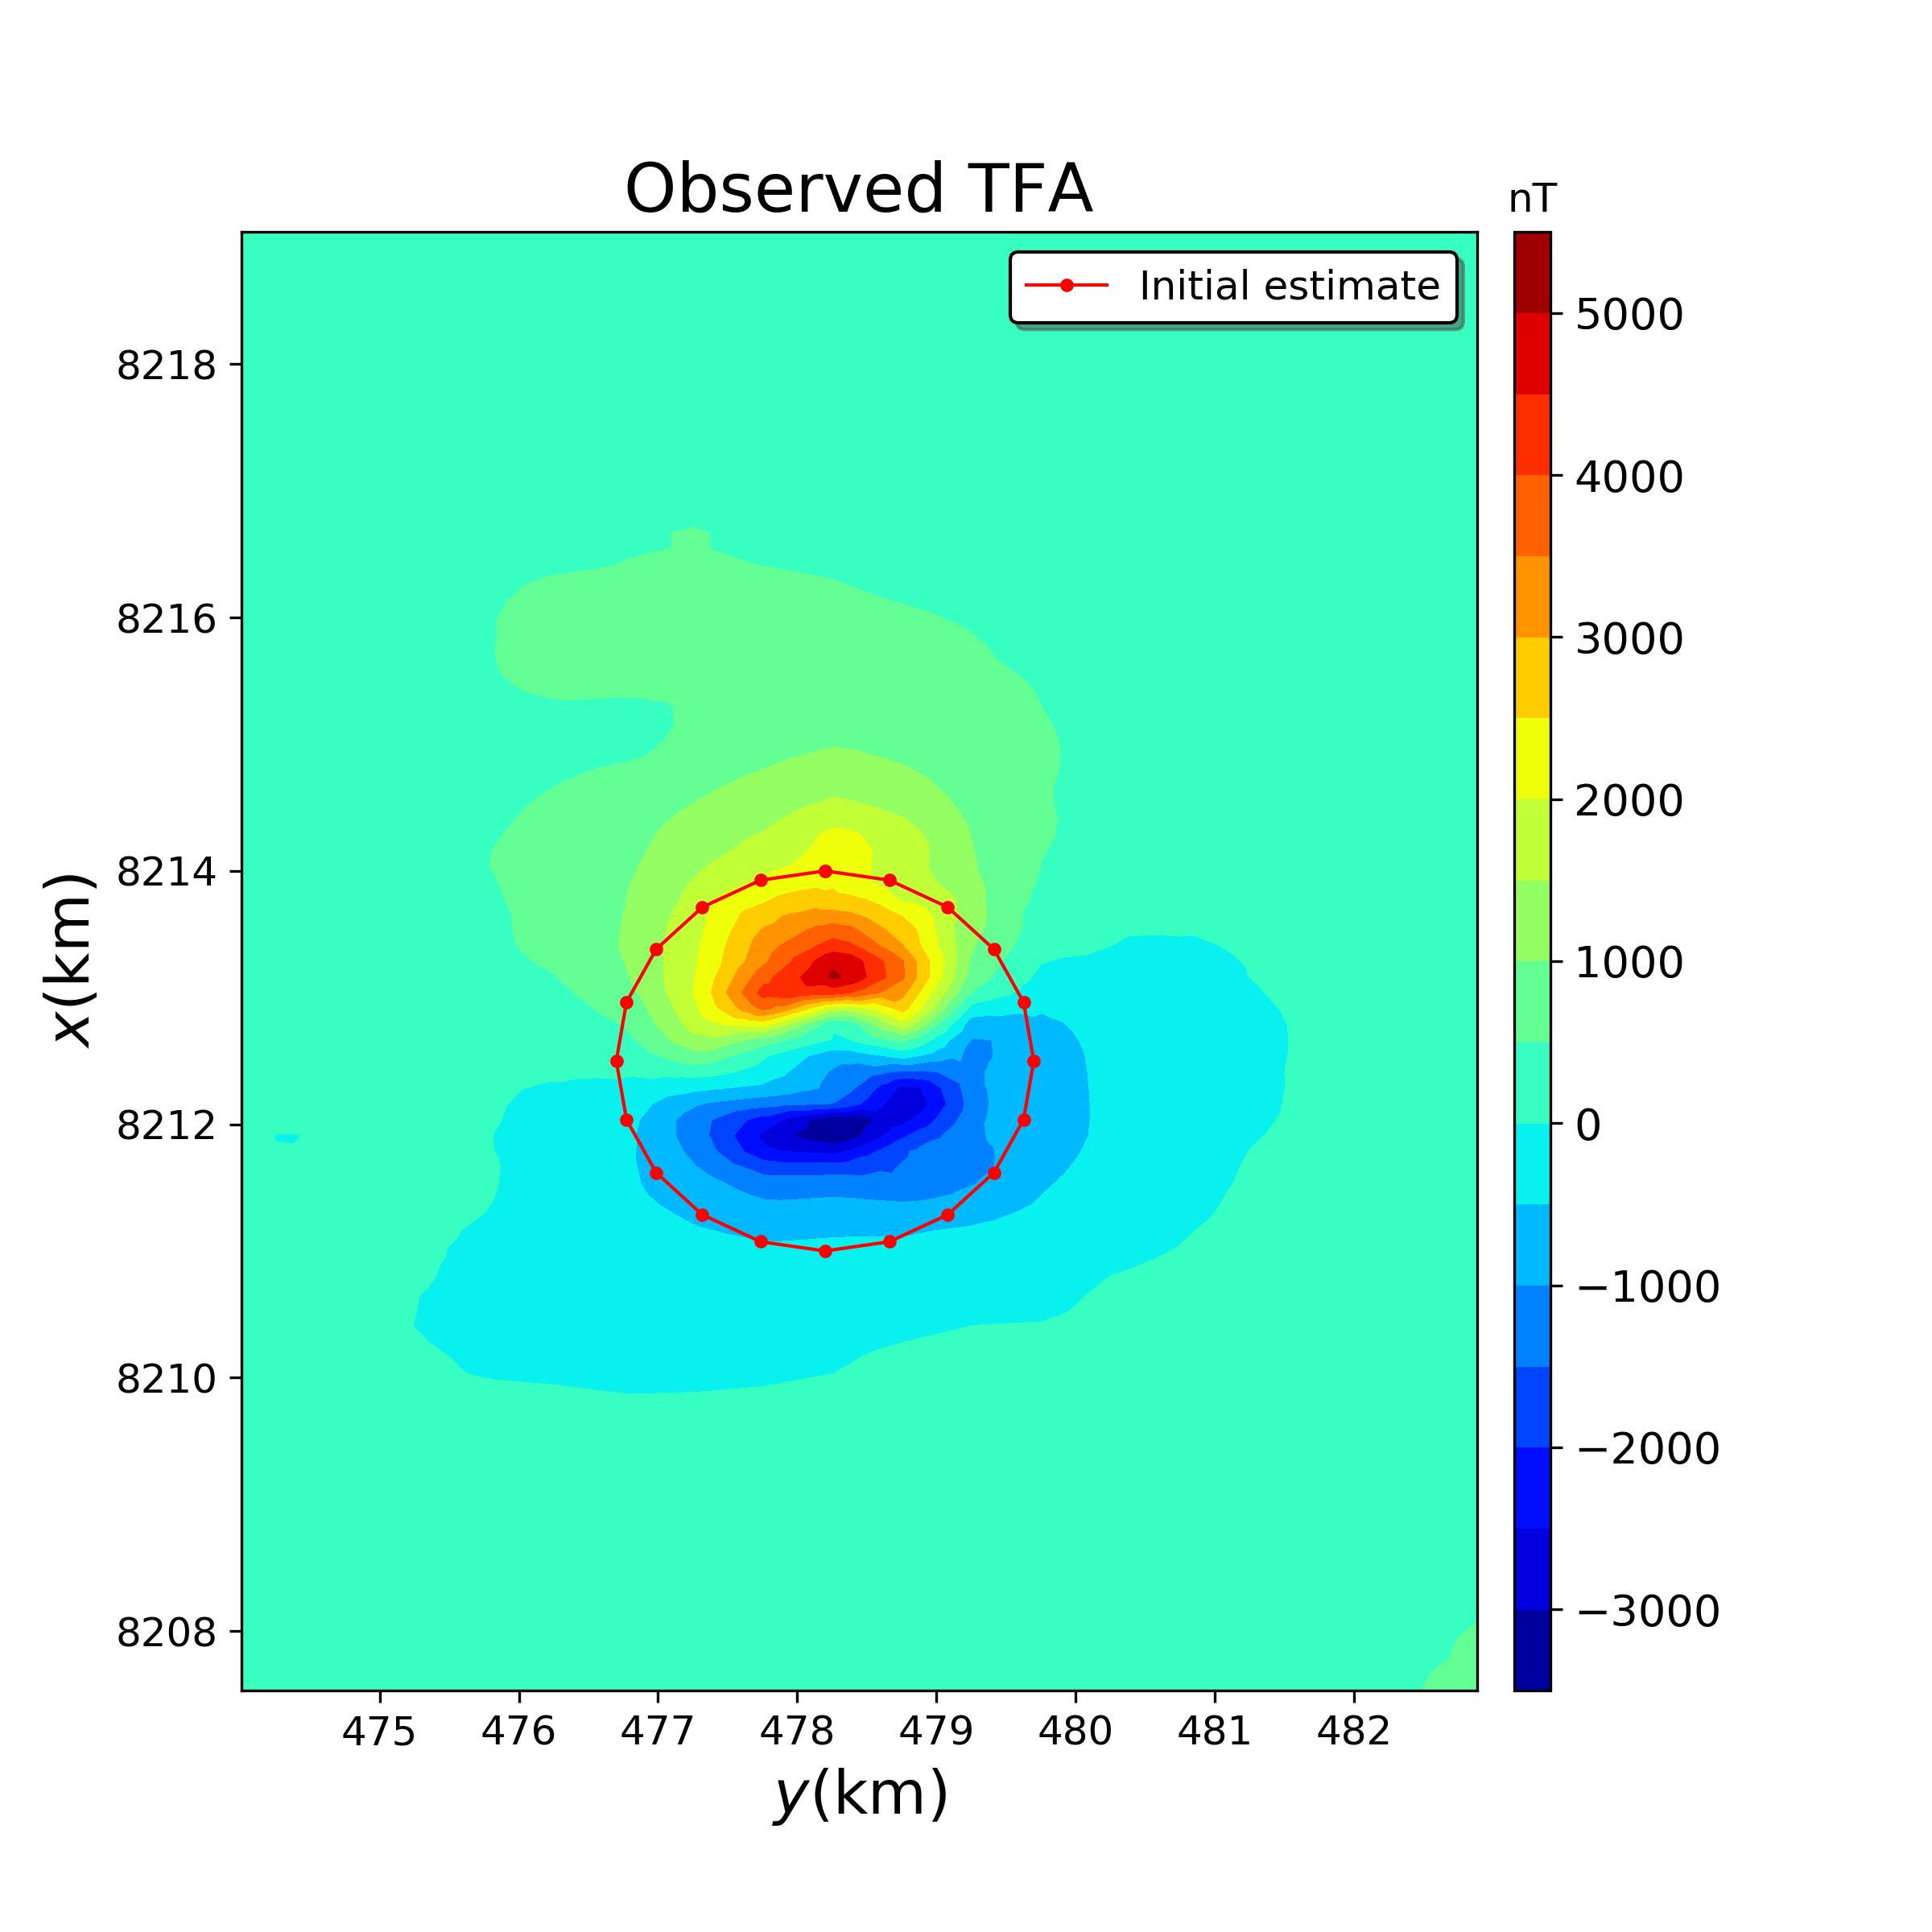

In [11]:
plt.figure(figsize=(8,8))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(kimberlite_model['prisms'][0], '.-k', xy2ne=True)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#source.set_label('Outcropping polygon')
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig('diorama_tfa_obs_data_true_inital.png', dpi=300)
#plt.show()

img(filename='diorama_tfa_obs_data_true_inital.png', width=800, height=800)

### Regularization parameters

In [12]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 1000.
dlamb = 10.      # step for Marquadt's parameter

a1 = 0.001   # adjacent radial distances within each prism
a2 = 0.001   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 0.01     # vertically adjacent origins
a6 = 0.00001   # zero order Tikhonov on adjacent radial distances
a7 = 0.000001     # zero order Tikhonov on thickness of each prism

In [13]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

### Inversion

In [14]:
d_fit, m_est, model_est, phi_list = mfun.levmarq_tf(xp, yp, zp, m0, M, L, delta, itmax,
                                                    itmax_marq, lamb, dlamb, epsilon,
                                                    mmin, mmax, m_out, dobs, inc, dec,
                                                    props, alpha, z0, dz)

it:  0   it_marq:  0   lambda: 1e+03   misfit: 4.5157e+05
it:  1   it_marq:  0   lambda: 1e+02   misfit: 4.4947e+05
it:  2   it_marq:  0   lambda: 1e+01   misfit: 4.1777e+05
it:  3   it_marq:  0   lambda: 1e+00   misfit: 2.8390e+05
it:  4   it_marq:  0   lambda: 1e-01   misfit: 2.7477e+05
it:  5   it_marq:  0   lambda: 1e-02   misfit: 4.1474e+05
it:  5   it_marq:  1   lambda: 1e-01   misfit: 3.7603e+05
it:  5   it_marq:  2   lambda: 1e+00   misfit: 3.9339e+05
it:  5   it_marq:  3   lambda: 1e+01   misfit: 3.7070e+05
it:  5   it_marq:  4   lambda: 1e+02   misfit: 2.6970e+05
it:  6   it_marq:  0   lambda: 1e+01   misfit: 2.2233e+05
it:  7   it_marq:  0   lambda: 1e+00   misfit: 1.6682e+05
it:  8   it_marq:  0   lambda: 1e-01   misfit: 2.0048e+05
it:  8   it_marq:  1   lambda: 1e+00   misfit: 1.7318e+05
it:  8   it_marq:  2   lambda: 1e+01   misfit: 1.4492e+05
it:  9   it_marq:  0   lambda: 1e+00   misfit: 1.7123e+05
it:  9   it_marq:  1   lambda: 1e+01   misfit: 1.3257e+05
it: 10   it_ma